Name  :Yoneshwar Babu 
ASU ID:1220454365

![](DOPR1P1.png)

In [165]:
# overhead
import logging
import math
import random
import numpy as np
import time
import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)


In [166]:
# environment parameters
FRAME_TIME = 0.1  # second, time interval
GRAVITY_ACCEL = 10.0  # m/s2, gravity constant
BOOST_ACCEL = 15.0  # m/s2, thrust constant
FUEL_CONSUMPTION_CONSTANT = 1  # We assume it is directly proportional to the acceleration

In [167]:
# define system dynamics

class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    @staticmethod
    def forward(state, action):
        """
        action:
        action[0]: to denote the thrust from rocket while landing in x direction
        action[1]: to denote the thrust from rocket while landing in y direction
        action[2]: to denote the fuel consumption #constraint
                    
        states:
        state[0] = p_x = position of rocket in x axis
        state[1] = x_booster = thrust of the rocket in x direction while landing. 
        state[2] = q_y = position of rocket in y axis
        state[3] = y_booster = thrust of the rocket in y direction while landing. 
        state[4] = fuel_consumption
        """

        delta_state_gravity = -t.tensor([0., 0., 0., GRAVITY_ACCEL * FRAME_TIME, 0.])# Applying the influence of gravity when the rocket is descending

       
        x_booster = action[0]    
        y_booster = action[1]
        delta_state_x = BOOST_ACCEL * FRAME_TIME * t.tensor([0., 1.0, 0., 0., 0.]) * x_booster
        delta_state_y = BOOST_ACCEL * FRAME_TIME * t.tensor([0., 0., 0., 1.0, 0.]) * y_booster

        # We assume that the rocket has some fixed amount of fuel and will be depleted based proportional to the acceleration
        # The added constraint is that there is only a fixed amount of fuel, and therefore any deviation from that value would
        # be considered as a loss. The goal is to consume fuel, but prioritize other parameters first. Therefore, the weightage to the fuel
        # would be kept low.

        delta_state_fuel_boost = t.tensor([0., 0., 0., 0., 2 * y_booster])

        #the velocity, gravity, thrust and  fuel boost is added and updated to the state
        state = state + delta_state_x + delta_state_y + delta_state_gravity + delta_state_fuel_boost


        # state updation
        step_mat = t.tensor([[1., FRAME_TIME, 0., 0., 0.],
                             [0., 1., 0., 0., 0.],
                             [0., 0., 1., FRAME_TIME, 0.],
                             [0., 0., 0., 1., 0.],
                             [0., 0., 0., 0., 1.]])
        state = t.matmul(step_mat, state)

        return state


In [168]:
# a deterministic controller

class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to you
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_output),  
            nn.Sigmoid()
        )

    def forward(self, state):
        action = self.network(state)
        return action


In [162]:
# the simulator that rolls out x(1), x(2), ..., x(T)

class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        # initial position of the rocket is set at (10, 20) with zero initial velocity
        state = [10.0, -2.0, 20.0, 1.0, 0]
        return t.tensor(state, requires_grad=False).float()

    # calculation of the loss function
    def error(self, state):
        
        # We assume that 300 is the fuel capacity
        # If consumed fuel is less than 300, then the error is 0
        
        if (state[4] < 300):
            fuel_error = 0
        else:
            fuel_error = 100
            
        #monitoring the state here
        print("For state ", state, fuel_error)
        return state[0] ** 2 + state[1] ** 2 + state[2] ** 2 + state[3] ** 2 + fuel_error


In [169]:
# set up the optimizer

class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.008)

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss

        self.optimizer.step(closure)
        return closure()

    def train(self, epochs):
        for epoch in range(epochs):
            loss = self.step()
            print('[%d] loss: %.3f' % (epoch + 1, loss))
            if epoch % 10 == 0:
                self.visualize()

    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        p_x1 = data[:, 0]
        q_y1 = data[:, 2]
        plt.xlabel('x')
        plt.ylabel('y')
        plt.plot(p_x1, q_y1)
        plt.grid()
        plt.show()
       
        tt = range(self.simulation.T)
        fuel = data[:, 4]
        plt.xlabel('Frame Time')
        plt.ylabel('Fuel consumption')
        plt.plot(tt, fuel, label='fuel')
        plt.grid()
        plt.show()
       
        data1 = np.array([self.simulation.action_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        x_boosterx = data1[:, 0]
        y_boostery = data1[:, 1]
        plt.xlabel('Frame Time')
        plt.ylabel('THRUST status')
        plt.plot(tt, x_boosterx, label='thrust in x position')
        plt.plot(tt, y_boostery, label='thrust in y position')
        plt.grid()
        plt.show()
       
        v_x = data[:, 1]
        v_y = data[:, 3]
        plt.xlabel('Frame Time')
        plt.ylabel('VELOCITY (m/s)')
        plt.plot(tt, v_x,c='m', label='x velocity')
        plt.plot(tt, v_y,c='b', label='y velocity')
        plt.grid()
        plt.show()




For state  tensor([ 426.4079,   85.2791, -132.9223,  -30.6848,   91.0870],
       grad_fn=<MvBackward>) 0
For state  tensor([ 426.0470,   85.2139, -132.8079,  -30.6651,   91.1133],
       grad_fn=<MvBackward>) 0
For state  tensor([ 424.6532,   84.9563, -132.3136,  -30.5774,   91.2301],
       grad_fn=<MvBackward>) 0
For state  tensor([ 421.3237,   84.3371, -131.0674,  -30.3554,   91.5260],
       grad_fn=<MvBackward>) 0
For state  tensor([ 415.2224,   83.2006, -128.7040,  -29.9354,   92.0861],
       grad_fn=<MvBackward>) 0
For state  tensor([ 406.9621,   81.6614, -125.4263,  -29.3563,   92.8582],
       grad_fn=<MvBackward>) 0
For state  tensor([ 399.1312,   80.2011, -122.2577,  -28.8006,   93.5992],
       grad_fn=<MvBackward>) 0
For state  tensor([ 392.4651,   78.9564, -119.5096,  -28.3224,   94.2368],
       grad_fn=<MvBackward>) 0
For state  tensor([ 386.3616,   77.8146, -116.9361,  -27.8789,   94.8281],
       grad_fn=<MvBackward>) 0
For state  tensor([ 380.2888,   76.6760, -114.

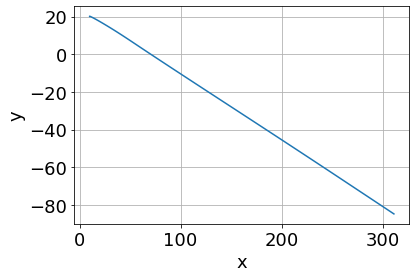

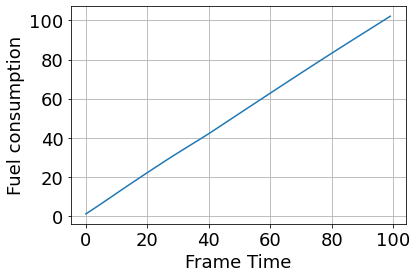

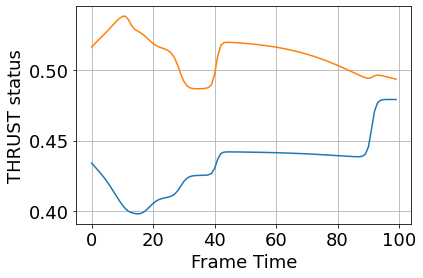

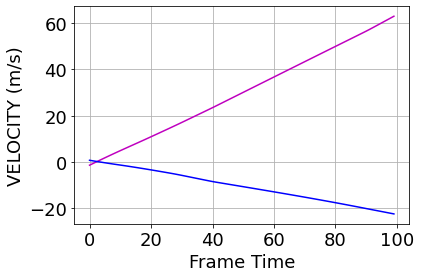

For state  tensor([311.0216,  62.9571, -84.7682, -22.3819, 102.1575],
       grad_fn=<MvBackward>) 0
For state  tensor([304.7861,  61.7433, -82.6494, -22.0881, 102.5492],
       grad_fn=<MvBackward>) 0
For state  tensor([297.8106,  60.3834, -80.2942, -21.7779, 102.9628],
       grad_fn=<MvBackward>) 0
For state  tensor([290.5057,  58.9547, -77.8491, -21.4686, 103.3752],
       grad_fn=<MvBackward>) 0
For state  tensor([283.3546,  57.5510, -75.5109, -21.1864, 103.7514],
       grad_fn=<MvBackward>) 0
For state  tensor([276.4896,  56.1984, -73.3507, -20.9373, 104.0835],
       grad_fn=<MvBackward>) 0
For state  tensor([269.7903,  54.8740, -71.3504, -20.7123, 104.3837],
       grad_fn=<MvBackward>) 0
For state  tensor([263.0616,  53.5401, -69.4381, -20.4883, 104.6822],
       grad_fn=<MvBackward>) 0
For state  tensor([256.3833,  52.2181, -67.5876, -20.2458, 105.0056],
       grad_fn=<MvBackward>) 0
For state  tensor([250.2037,  51.0076, -65.8723, -19.9895, 105.3474],
       grad_fn=<MvBac

For state  tensor([101.7635,  20.2400,  -6.6420,  -6.7246, 123.0339],
       grad_fn=<MvBackward>) 0
For state  tensor([100.8624,  20.0342,  -6.6228,  -6.6893, 123.0810],
       grad_fn=<MvBackward>) 0
[5] loss: 10663.206
For state  tensor([100.8624,  20.0342,  -6.6228,  -6.6893, 123.0810],
       grad_fn=<MvBackward>) 0
For state  tensor([ 99.9811,  19.8349,  -6.6088,  -6.6548, 123.1269],
       grad_fn=<MvBackward>) 0
For state  tensor([ 99.1147,  19.6409,  -6.5982,  -6.6206, 123.1725],
       grad_fn=<MvBackward>) 0
For state  tensor([ 98.2589,  19.4511,  -6.5881,  -6.5859, 123.2188],
       grad_fn=<MvBackward>) 0
For state  tensor([ 97.4097,  19.2641,  -6.5751,  -6.5499, 123.2668],
       grad_fn=<MvBackward>) 0
For state  tensor([ 96.5660,  19.0792,  -6.5563,  -6.5122, 123.3170],
       grad_fn=<MvBackward>) 0
For state  tensor([ 95.7281,  18.8965,  -6.5304,  -6.4728, 123.3696],
       grad_fn=<MvBackward>) 0
For state  tensor([ 94.8969,  18.7158,  -6.4971,  -6.4317, 123.4243],
 

For state  tensor([ 51.8723,   9.8834,  -2.4750,  -5.4206, 124.7725],
       grad_fn=<MvBackward>) 0
For state  tensor([ 51.4077,   9.7940,  -2.4808,  -5.4202, 124.7731],
       grad_fn=<MvBackward>) 0
For state  tensor([ 50.9461,   9.7016,  -2.3383,  -5.3853, 124.8195],
       grad_fn=<MvBackward>) 0
For state  tensor([ 50.4778,   9.6114,  -2.3358,  -5.3825, 124.8233],
       grad_fn=<MvBackward>) 0
For state  tensor([ 50.0237,   9.5215,  -2.2249,  -5.3547, 124.8604],
       grad_fn=<MvBackward>) 0
[9] loss: 2626.657
For state  tensor([ 50.0237,   9.5215,  -2.2249,  -5.3547, 124.8604],
       grad_fn=<MvBackward>) 0
For state  tensor([ 49.5687,   9.4335,  -2.2060,  -5.3478, 124.8696],
       grad_fn=<MvBackward>) 0
For state  tensor([ 49.1240,   9.3462,  -2.1204,  -5.3256, 124.8992],
       grad_fn=<MvBackward>) 0
For state  tensor([ 48.6806,   9.2603,  -2.0893,  -5.3157, 124.9124],
       grad_fn=<MvBackward>) 0
For state  tensor([ 48.2455,   9.1752,  -2.0178,  -5.2966, 124.9378],
  

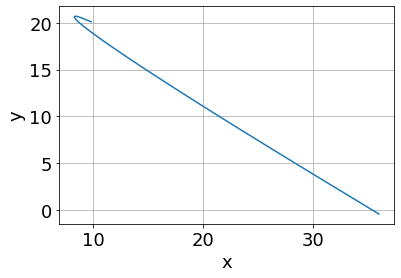

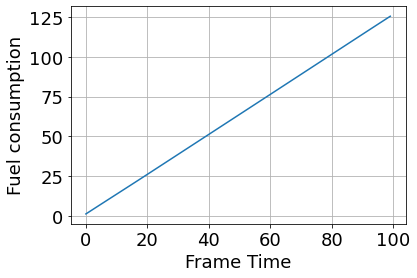

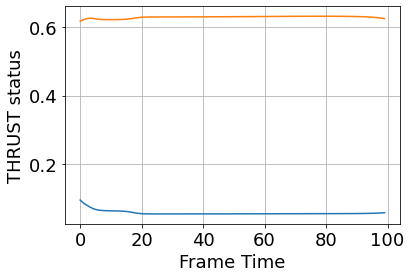

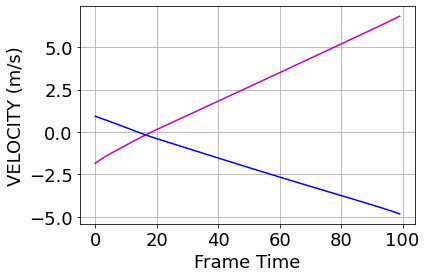

For state  tensor([ 35.9941,   6.8201,  -0.3946,  -4.8366, 125.5512],
       grad_fn=<MvBackward>) 0
For state  tensor([ 35.6649,   6.7576,  -0.3541,  -4.8245, 125.5674],
       grad_fn=<MvBackward>) 0
For state  tensor([ 35.3284,   6.6937,  -0.3083,  -4.8112, 125.5851],
       grad_fn=<MvBackward>) 0
For state  tensor([ 34.9837,   6.6282,  -0.2643,  -4.7982, 125.6024],
       grad_fn=<MvBackward>) 0
For state  tensor([ 34.6309,   6.5613,  -0.2173,  -4.7845, 125.6206],
       grad_fn=<MvBackward>) 0
For state  tensor([ 34.2695,   6.4928,  -0.1704,  -4.7707, 125.6391],
       grad_fn=<MvBackward>) 0
For state  tensor([ 3.3900e+01,  6.4227e+00, -1.2160e-01, -4.7565e+00,  1.2566e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([ 3.3522e+01,  6.3512e+00, -7.2131e-02, -4.7420e+00,  1.2568e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([ 3.3136e+01,  6.2783e+00, -2.1538e-02, -4.7272e+00,  1.2570e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([ 3.2744e+01,  6.2041e+00,  

For state  tensor([ 15.5745,   3.0036,   1.2135,  -4.2257, 126.3657],
       grad_fn=<MvBackward>) 0
For state  tensor([ 15.4449,   2.9807,   1.2125,  -4.2178, 126.3763],
       grad_fn=<MvBackward>) 0
[15] loss: 266.689
For state  tensor([ 15.4449,   2.9807,   1.2125,  -4.2178, 126.3763],
       grad_fn=<MvBackward>) 0
For state  tensor([ 15.3160,   2.9566,   1.2088,  -4.2153, 126.3796],
       grad_fn=<MvBackward>) 0
For state  tensor([ 15.1898,   2.9343,   1.2054,  -4.2081, 126.3892],
       grad_fn=<MvBackward>) 0
For state  tensor([ 15.0644,   2.9110,   1.2036,  -4.2043, 126.3942],
       grad_fn=<MvBackward>) 0
For state  tensor([ 14.9414,   2.8892,   1.1983,  -4.1978, 126.4030],
       grad_fn=<MvBackward>) 0
For state  tensor([ 14.8190,   2.8667,   1.1984,  -4.1928, 126.4096],
       grad_fn=<MvBackward>) 0
For state  tensor([ 14.6986,   2.8453,   1.1909,  -4.1868, 126.4176],
       grad_fn=<MvBackward>) 0
For state  tensor([ 14.5783,   2.8233,   1.1939,  -4.1805, 126.4260],
  

For state  tensor([  7.1889,   1.5225,   0.8311,  -3.3678, 127.5097],
       grad_fn=<MvBackward>) 0
For state  tensor([  7.1125,   1.5089,   0.8193,  -3.3554, 127.5261],
       grad_fn=<MvBackward>) 0
For state  tensor([  7.0370,   1.4953,   0.8212,  -3.3404, 127.5461],
       grad_fn=<MvBackward>) 0
For state  tensor([  6.9630,   1.4821,   0.8099,  -3.3278, 127.5630],
       grad_fn=<MvBackward>) 0
[19] loss: 62.410
For state  tensor([  6.9630,   1.4821,   0.8099,  -3.3278, 127.5630],
       grad_fn=<MvBackward>) 0
For state  tensor([  6.8897,   1.4688,   0.8118,  -3.3128, 127.5830],
       grad_fn=<MvBackward>) 0
For state  tensor([  6.8179,   1.4560,   0.8002,  -3.2998, 127.6003],
       grad_fn=<MvBackward>) 0
For state  tensor([  6.7466,   1.4430,   0.8029,  -3.2847, 127.6204],
       grad_fn=<MvBackward>) 0
For state  tensor([  6.6768,   1.4305,   0.7906,  -3.2714, 127.6381],
       grad_fn=<MvBackward>) 0
For state  tensor([  6.6072,   1.4178,   0.7939,  -3.2561, 127.6584],
   

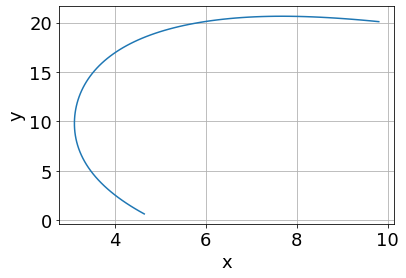

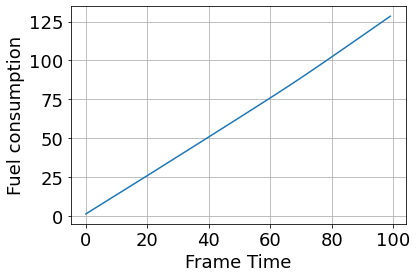

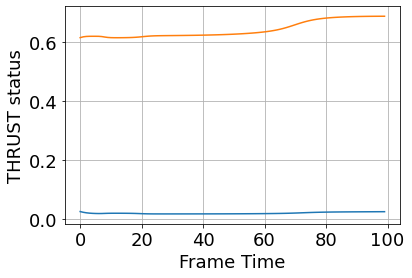

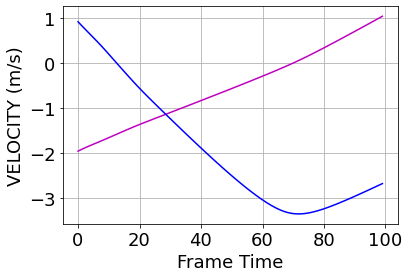

For state  tensor([  4.6458,   1.0463,   0.6214,  -2.6841, 128.4212],
       grad_fn=<MvBackward>) 0
For state  tensor([  4.5983,   1.0368,   0.6208,  -2.6641, 128.4479],
       grad_fn=<MvBackward>) 0
For state  tensor([  4.5512,   1.0273,   0.6112,  -2.6458, 128.4723],
       grad_fn=<MvBackward>) 0
For state  tensor([  4.5043,   1.0177,   0.6104,  -2.6255, 128.4994],
       grad_fn=<MvBackward>) 0
For state  tensor([  4.4578,   1.0082,   0.6010,  -2.6069, 128.5241],
       grad_fn=<MvBackward>) 0
For state  tensor([  4.4115,   0.9988,   0.6000,  -2.5863, 128.5516],
       grad_fn=<MvBackward>) 0
For state  tensor([  4.3654,   0.9893,   0.5908,  -2.5674, 128.5768],
       grad_fn=<MvBackward>) 0
For state  tensor([  4.3195,   0.9798,   0.5896,  -2.5465, 128.6047],
       grad_fn=<MvBackward>) 0
For state  tensor([  4.2739,   0.9704,   0.5805,  -2.5273, 128.6303],
       grad_fn=<MvBackward>) 0
For state  tensor([  4.2284,   0.9609,   0.5791,  -2.5060, 128.6586],
       grad_fn=<MvBac

For state  tensor([  1.7747,   0.4184,   0.2933,  -1.3682, 130.1757],
       grad_fn=<MvBackward>) 0
For state  tensor([  1.7548,   0.4139,   0.2931,  -1.3579, 130.1895],
       grad_fn=<MvBackward>) 0
For state  tensor([  1.7356,   0.4096,   0.2885,  -1.3486, 130.2019],
       grad_fn=<MvBackward>) 0
For state  tensor([  1.7162,   0.4053,   0.2883,  -1.3384, 130.2155],
       grad_fn=<MvBackward>) 0
For state  tensor([  1.6975,   0.4011,   0.2839,  -1.3291, 130.2279],
       grad_fn=<MvBackward>) 0
For state  tensor([  1.6785,   0.3968,   0.2836,  -1.3189, 130.2415],
       grad_fn=<MvBackward>) 0
For state  tensor([  1.6603,   0.3927,   0.2793,  -1.3096, 130.2538],
       grad_fn=<MvBackward>) 0
For state  tensor([  1.6418,   0.3885,   0.2789,  -1.2995, 130.2673],
       grad_fn=<MvBackward>) 0
For state  tensor([  1.6241,   0.3845,   0.2747,  -1.2903, 130.2796],
       grad_fn=<MvBackward>) 0
For state  tensor([  1.6060,   0.3805,   0.2743,  -1.2802, 130.2931],
       grad_fn=<MvBac

For state  tensor([ 7.3192e-01,  1.7232e-01,  1.2812e-01, -6.5600e-01,  1.3113e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([ 7.2299e-01,  1.7005e-01,  1.2751e-01, -6.4889e-01,  1.3113e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([ 7.1467e-01,  1.6793e-01,  1.2480e-01, -6.4255e-01,  1.3114e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([ 7.0596e-01,  1.6571e-01,  1.2419e-01, -6.3561e-01,  1.3115e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([ 6.9784e-01,  1.6364e-01,  1.2159e-01, -6.2941e-01,  1.3116e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([ 6.8937e-01,  1.6149e-01,  1.2101e-01, -6.2264e-01,  1.3117e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([ 6.8147e-01,  1.5947e-01,  1.1846e-01, -6.1660e-01,  1.3118e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([ 6.7320e-01,  1.5736e-01,  1.1792e-01, -6.0996e-01,  1.3119e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([ 6.6552e-01,  1.5540e-01,  1.1545e-01, -6.0406e-01,  

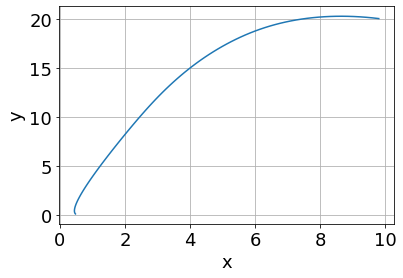

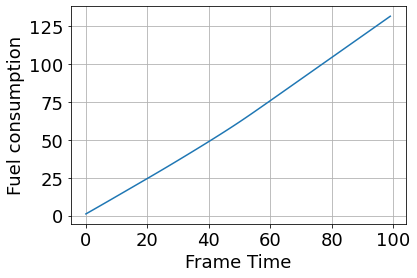

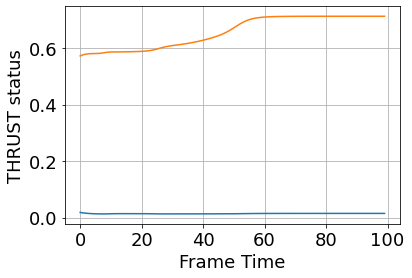

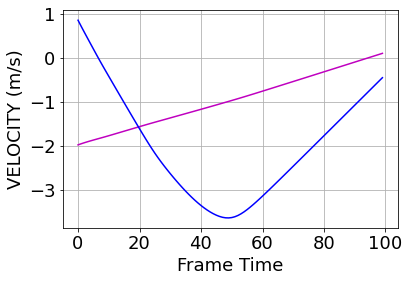

For state  tensor([ 4.7389e-01,  1.0641e-01,  8.1701e-02, -4.4659e-01,  1.3140e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([ 4.6869e-01,  1.0508e-01,  8.1536e-02, -4.4187e-01,  1.3141e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([ 4.6388e-01,  1.0384e-01,  8.0101e-02, -4.3772e-01,  1.3142e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([ 4.5884e-01,  1.0255e-01,  7.9930e-02, -4.3309e-01,  1.3142e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([ 4.5416e-01,  1.0134e-01,  7.8551e-02, -4.2900e-01,  1.3143e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([ 4.4926e-01,  1.0008e-01,  7.8397e-02, -4.2446e-01,  1.3143e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([ 4.4473e-01,  9.8915e-02,  7.7043e-02, -4.2045e-01,  1.3144e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([ 4.3997e-01,  9.7688e-02,  7.6887e-02, -4.1598e-01,  1.3145e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([ 4.3556e-01,  9.6552e-02,  7.5562e-02, -4.1204e-01,  

For state  tensor([ 2.4300e-01,  4.5641e-02,  4.0438e-02, -2.2217e-01,  1.3170e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([ 2.4061e-01,  4.4978e-02,  4.0272e-02, -2.1971e-01,  1.3171e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([ 2.3839e-01,  4.4364e-02,  3.9542e-02, -2.1754e-01,  1.3171e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([ 2.3604e-01,  4.3712e-02,  3.9378e-02, -2.1513e-01,  1.3171e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([ 2.3387e-01,  4.3108e-02,  3.8663e-02, -2.1300e-01,  1.3172e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([ 2.3156e-01,  4.2464e-02,  3.8511e-02, -2.1063e-01,  1.3172e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([ 2.2944e-01,  4.1872e-02,  3.7800e-02, -2.0854e-01,  1.3172e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([ 2.2716e-01,  4.1234e-02,  3.7655e-02, -2.0621e-01,  1.3173e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([ 2.2508e-01,  4.0652e-02,  3.6962e-02, -2.0416e-01,  

For state  tensor([ 1.2407e-01,  1.1558e-02,  1.9252e-02, -1.0512e-01,  1.3186e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([ 1.2301e-01,  1.1242e-02,  1.8908e-02, -1.0411e-01,  1.3186e+02],
       grad_fn=<MvBackward>) 0
[38] loss: 0.026
For state  tensor([ 1.2301e-01,  1.1242e-02,  1.8908e-02, -1.0411e-01,  1.3186e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([ 1.2182e-01,  1.0890e-02,  1.8867e-02, -1.0294e-01,  1.3186e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([ 1.2077e-01,  1.0578e-02,  1.8524e-02, -1.0197e-01,  1.3186e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([ 1.1962e-01,  1.0233e-02,  1.8480e-02, -1.0082e-01,  1.3187e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([ 1.1858e-01,  9.9255e-03,  1.8162e-02, -9.9868e-02,  1.3187e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([ 1.1746e-01,  9.5904e-03,  1.8100e-02, -9.8756e-02,  1.3187e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([ 1.1645e-01,  9.2887e-03,  1.7775e-0

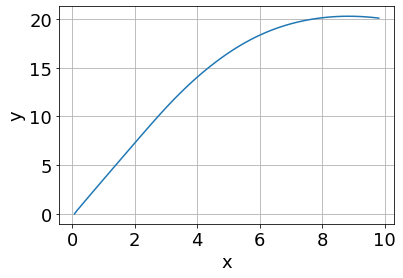

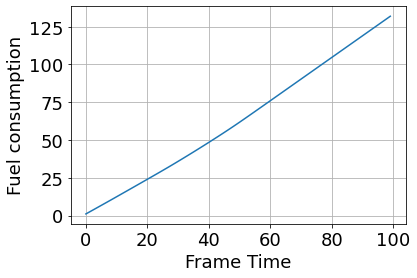

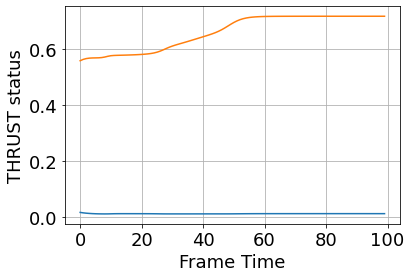

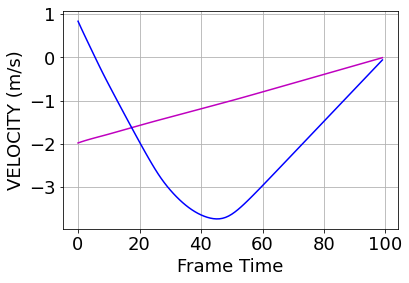

For state  tensor([ 7.1492e-02, -4.4639e-03,  9.7170e-03, -5.6424e-02,  1.3192e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([ 7.0832e-02, -4.6755e-03,  9.6777e-03, -5.5796e-02,  1.3193e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([ 7.0253e-02, -4.8631e-03,  9.4942e-03, -5.5279e-02,  1.3193e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([ 6.9596e-02, -5.0750e-03,  9.4467e-03, -5.4657e-02,  1.3193e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([ 6.9016e-02, -5.2620e-03,  9.2717e-03, -5.4144e-02,  1.3193e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([ 6.8387e-02, -5.4658e-03,  9.2316e-03, -5.3546e-02,  1.3193e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([ 6.7828e-02, -5.6481e-03,  9.0716e-03, -5.3039e-02,  1.3193e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([ 6.7210e-02, -5.8495e-03,  9.0325e-03, -5.2460e-02,  1.3193e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([ 6.6653e-02, -6.0300e-03,  8.8688e-03, -5.1963e-02,  

For state  tensor([ 3.8957e-02, -1.5287e-02,  4.8772e-03, -2.8066e-02,  1.3196e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([ 3.8680e-02, -1.5384e-02,  4.8142e-03, -2.7835e-02,  1.3196e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([ 3.8364e-02, -1.5496e-02,  4.8227e-03, -2.7540e-02,  1.3196e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([ 3.8096e-02, -1.5591e-02,  4.7380e-03, -2.7317e-02,  1.3196e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([ 3.7767e-02, -1.5708e-02,  4.7529e-03, -2.7010e-02,  1.3196e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([ 3.7505e-02, -1.5801e-02,  4.6618e-03, -2.6799e-02,  1.3196e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([ 3.7165e-02, -1.5920e-02,  4.6608e-03, -2.6495e-02,  1.3196e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([ 3.6899e-02, -1.6013e-02,  4.5656e-03, -2.6292e-02,  1.3196e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([ 3.6564e-02, -1.6132e-02,  4.5674e-03, -2.5993e-02,  

For state  tensor([ 2.3600e-02, -2.0647e-02,  2.6455e-03, -1.5223e-02,  1.3198e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([ 2.3432e-02, -2.0699e-02,  2.6574e-03, -1.5074e-02,  1.3198e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([ 2.3299e-02, -2.0741e-02,  2.6213e-03, -1.4974e-02,  1.3198e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([ 2.3133e-02, -2.0792e-02,  2.6074e-03, -1.4839e-02,  1.3198e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([ 2.2988e-02, -2.0837e-02,  2.5858e-03, -1.4724e-02,  1.3198e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([ 2.2848e-02, -2.0880e-02,  2.5768e-03, -1.4607e-02,  1.3198e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([ 2.2707e-02, -2.0924e-02,  2.5551e-03, -1.4492e-02,  1.3198e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([ 2.2558e-02, -2.0967e-02,  2.5459e-03, -1.4383e-02,  1.3198e+02],
       grad_fn=<MvBackward>) 0
For state  tensor([ 2.2427e-02, -2.1008e-02,  2.5101e-03, -1.4267e-02,  

In [170]:
# Now it's time to run the code!
T = 100  # number of time steps
dim_input = 5  # state space dimensions
dim_hidden = 20  # latent dimensions
dim_output = 2  # action space dimensions
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T)  # define simulation
o = Optimize(s)  # define optimizer
o.train(50)  # solve the optimization problem

Documentation:

    We are considering a rocket state x(t) is represented by its distance to the ground d(t) and its velocity v(t). 
The formulation is similar to the given. 
    

Initial values:
    we assume the following,
    
    FRAME_TIME    = 0.1 second,
    GRAVITY_ACCEL = 9.8 m/s^2,
    BOOST_ACCEL   = 12.0 m/s^2,
    FUEL_CONSUMPTION_CONSTANT = 1. 
    
   

    I have added fuel constraint, We assume that the rocket has some fixed amount of fuel and will be depleted based proportional to the acceleration. The added constraint is that there is only for a fixed amount of fuel and therefore any deviation from that value would be considered as a loss. The goal is to consume fuel, but prioritize other parameters first. Therefore, the weightage to the fuel would be kept low. 
     
    I have added fuel consumption. If fuel consumption exceeds, then the loss never goes to 0. Currently, fuel capacity is set to 300 units. 
 
    We assume that 300 units of fuel is the fuel capacity.
    
    If the consumed fuel is less than 300 units, then the error is 0.

Conclusion:
    
    I have plotted four graphs, the values get converged as the iterations goes on. Nearly at 50 iterations, we can say that the rocket landing problem is optimized.      